In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Make plots nice
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# Set-up

We'll define our space of actions / alternatives.

In [37]:
from holmespy.alternativesets import ContinuousAlternativeSet
x_bnds = [[0, 1]]
A = ContinuousAlternativeSet(x_bnds)

Next we'll define our deterministic optimizer

In [38]:
from holmespy.optimizers import ContinuousOptimizer
optimizer = ContinuousOptimizer(A)

Next we'll build the Gaussian Process prior from which we'll sample a ground truth.

In [39]:
from holmespy.beliefmodels import GaussianProcessBeliefs
B_0 = GaussianProcessBeliefs(0, 2**2, [0.1], num_hyperparameter_fits = 10)

We have to define an observation model, which tells us how beliefs map to observations (sampling outputs) and how observations map to beliefs (Bayesian update). Since we're using a Gaussian Process to represent our outputs directly (as opposed to beliefs on parameters) we'll use the `GaussianProcessObservationModel`, which just wraps around the `GaussianProcessBeliefs`. We have to specify the (homoscedastic) noise variance `sigma_W**2`.

In [40]:
from holmespy.observationmodels import GaussianProcessObservationModel
SIGMA_W = 0.2
obs_model = GaussianProcessObservationModel(SIGMA_W**2)

Polices require **states**, which could be complex, but for Bayesian optimization, the only state variable is the Bayesian belief, $B^n$ (including the time index $n$. We also specify the experiment budget, to define terminal states, the set of actions, an observation model (for the Bayesian update), and an optimizer (for final rewards).

In [41]:
from holmespy.state import BayesianOptimizationState
NUM_EXPS = 20
S_0 = BayesianOptimizationState(B_0, 0, NUM_EXPS, A, optimizer)

# Using the EI Policy

We want to use the EI policy to make a suggestion of which alternative to run.

In [42]:
from holmespy.policies import EIPolicy
INCLUDE_NOISE_VARIANCE = False

pi = EIPolicy(optimizer, obs_model, include_noise_var = INCLUDE_NOISE_VARIANCE)

# Make the suggestion according to EI
x = pi.suggest(S_0)
print(x)

[0.65599616]


We'll use the EI policy to optimize. We'll simulate this procedure, so we need a ground truth response function. To get one, we'll just sample from the Gaussian process prior.

Text(0, 0.5, 'y')

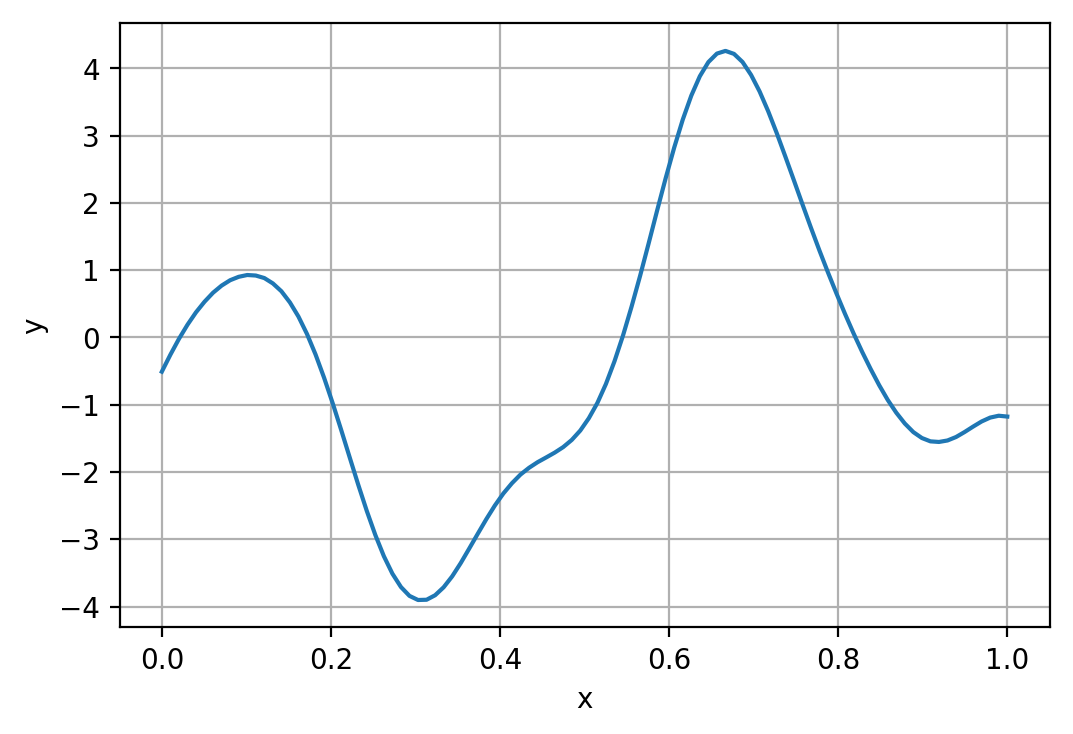

In [43]:
# Sample the ground truth
f_star = B_0.sample()

# Plot it to visualize
x_plot = np.linspace(0, 1, 100)
y_plot = [f_star([x]) for x in x_plot]

plt.plot(x_plot, y_plot)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

We'll simulate the decision-experiment-update closed loop:

In [44]:
x = np.zeros([NUM_EXPS,1])
y = np.zeros(NUM_EXPS)
states = [S_0]

for n in range(NUM_EXPS-1):
    
    # Policy suggestion
    x[n,:] = pi.suggest(states[n])
    
    # simulated noisy observation
    y[n+1] = f_star(x[n]) + np.random.normal(0, SIGMA_W)
    
    # update beliefs
    S_posterior = states[n].step(x[n,:], y[n+1], obs_model)
    states.append(S_posterior)

The final suggestion is a pure exploitation suggestion to get the argmax of the posterior mean.

In [34]:
from holmespy.policies import ExploitationPolicy
pi_explt = ExploitationPolicy(optimizer, obs_model)

# The posterior state
S_N = states[-1]

# Get the estimated best alternative.
x_best = pi_explt.suggest(S_N)
print(x_best)

[0.772681]


Below we'll plot the truth, posterior beliefs and observations.

TypeError: 'float' object is not subscriptable

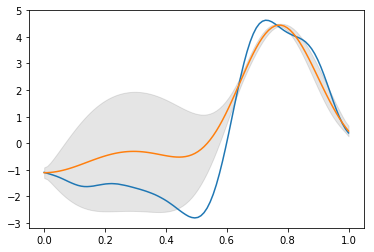

In [35]:
# Plot the truth
plt.plot(x_plot, y_plot)

# Posterior beliefs - mean and uncertainty
f_N = [obs_model.mean(S_N, [x]) for x in x_plot]
sig_N = np.sqrt([obs_model.covariance(S_N, [x], [x]) for x in x_plot])
plt.plot(x_plot, f_N)
plt.fill_between(x_plot, f_N + sig_N, f_N - sig_N, color = 'k', alpha = 0.1)

# Plot the data
plt.errorbar(x[:-1], y[1:], SIGMA_W, linestyle='None', linewidth=2, marker = 'o')

plt.legend(['Ground Truth', 'Posterior Mean', 'Posterior Uncertainty', 'Data'])
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

We can also plot the acquisition function.

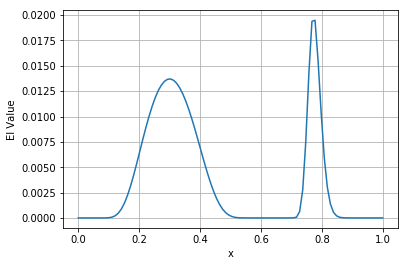

In [28]:
acq_fun = pi.build_acquisition_function(S_N)
y_acq = [acq_fun([x]) for x in x_plot]
plt.plot(x_plot, y_acq)
plt.xlabel('x')
plt.ylabel('EI Value')
plt.grid()

We can do this for any state, and not just the posterior state in case we want to get a better understanding of how the decisions are being made.

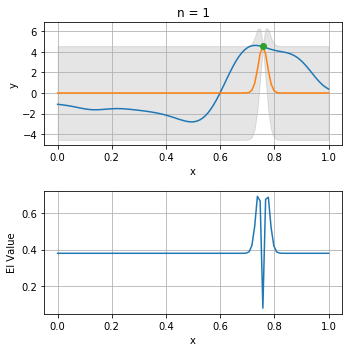

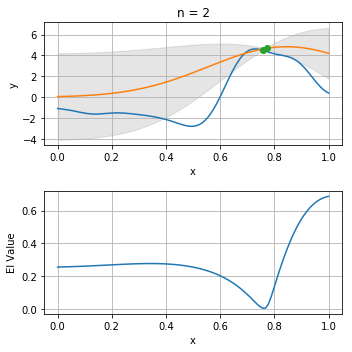

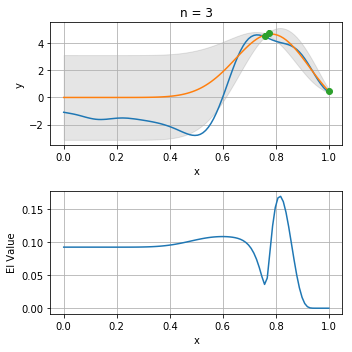

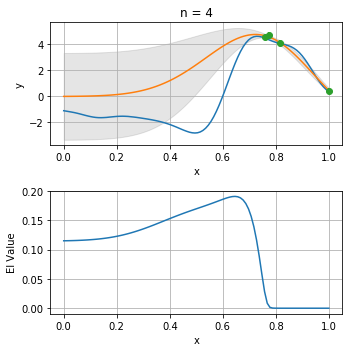

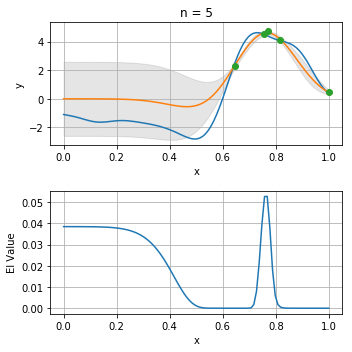

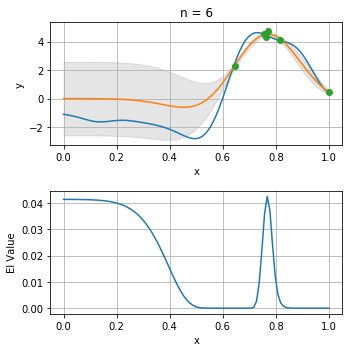

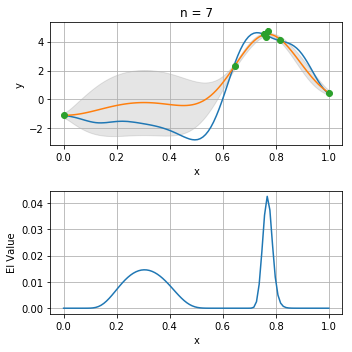

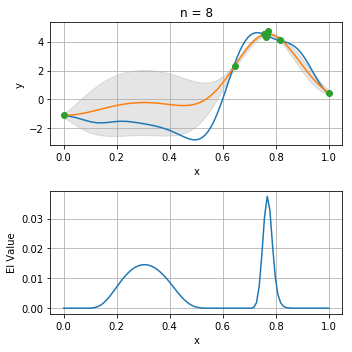

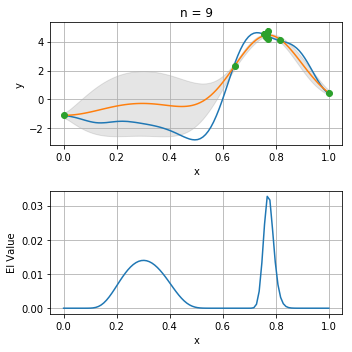

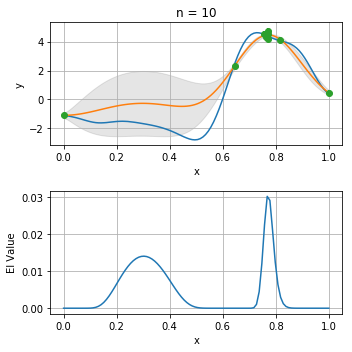

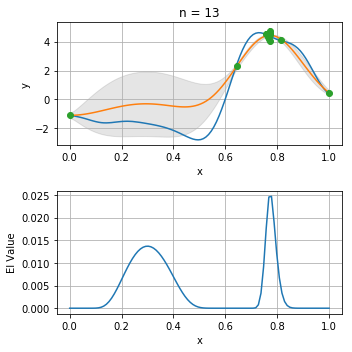

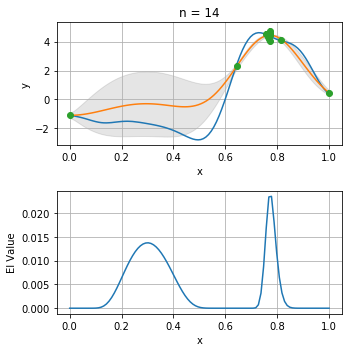

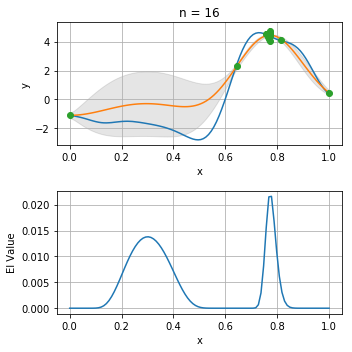

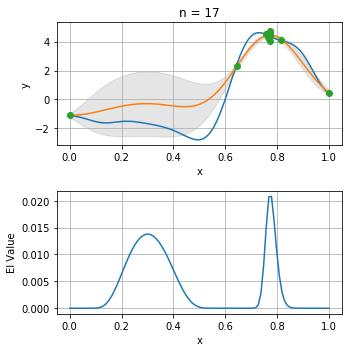

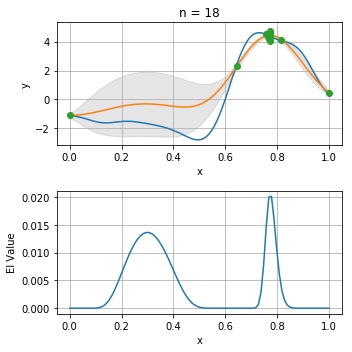

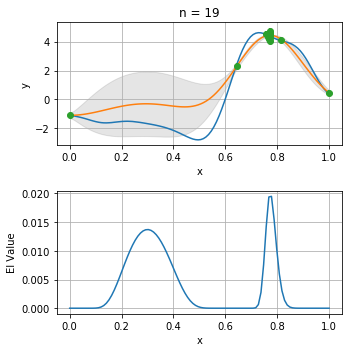

In [29]:
for n in range(NUM_EXPS):
    
    plt.figure(figsize=(5, 5))
    
    # Plot the EI policy
    plt.subplot(2, 1, 2)
    acq_fun = pi.build_acquisition_function(states[n])
    y_acq = [acq_fun([x]) for x in x_plot]
    plt.plot(x_plot, y_acq)
    plt.xlabel('x')
    plt.ylabel('EI Value')
    plt.grid()
  
    # Plot the truth, beliefs and data
    plt.subplot(2, 1, 1)
    plt.plot(x_plot, y_plot)
    f_n = [obs_model.mean(states[n], [x]) for x in x_plot]
    sig_n = np.sqrt([obs_model.covariance(states[n], [x], [x]) for x in x_plot])
    plt.plot(x_plot, f_n)
    plt.fill_between(x_plot, f_n + sig_n, f_n - sig_n, color = 'k', alpha = 0.1)
    plt.errorbar(x[:n], y[1:(n+1)], SIGMA_W, linestyle='None', linewidth=2, marker = 'o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.title('n = %d'% n)
        
    plt.tight_layout()
    plt.show()

#### 0
x = [0.9]
mu(x) = 0.0
y_star = 0.0
delta(x) = 0.0
var(x) = 4.0
data_var(x) = 0.04000000000000001
sigma2_x = 4.0
sigma_x = 2.0
Phi = 0.5
phi = 0.3989422804014327
#### 1
x = [0.9]
mu(x) = 1.8284762369281358e-15
y_star = 4.549423184758499
delta(x) = -4.549423184758497
var(x) = 20.737173980045124
data_var(x) = 0.04000000000000001
sigma2_x = 20.737173980045124
sigma_x = 4.553808733362121
Phi = 0.15888839621245077
phi = 0.24220375451821025
#### 2
x = [0.9]
mu(x) = 4.749878828279066
y_star = 4.834207284359973
delta(x) = -0.08432845608090744
var(x) = 2.184408471853894
data_var(x) = 0.04000000000000001
sigma2_x = 2.184408471853894
sigma_x = 1.4779744489854667
Phi = 0.47724998429310184
phi = 0.39829343518757726
#### 3
x = [0.9]
mu(x) = 2.9487915510535605
y_star = 4.689117605751753
delta(x) = -1.7403260546981927
var(x) = 0.969673857368667
data_var(x) = 0.04000000000000001
sigma2_x = 0.969673857368667
sigma_x = 0.9847201924245623
Phi = 0.03858644529685723
phi = 0.08368737697541542
#### 4
x 

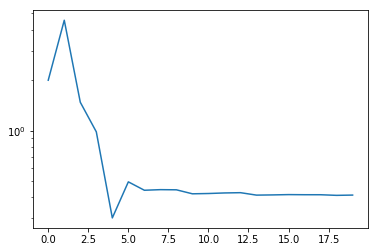

In [31]:
x = 0.9
stds = np.zeros(len(states))

for i in range(len(states)):
    stds[i] = np.sqrt(states[i].current_beliefs.covariance_x([x], [x]))
    print('#### %d' % i)
    acq_fun = pi.build_acquisition_function(states[i])
    acq_fun([x], verbose = True)

plt.plot(stds)
plt.yscale('log')


# Monte Carlo Estimation of Expected Improvement acquisition function.

Below, we'll estimate the expected improvement

$$ \nu(x) = \mathbb E\left[ \left[[\hat f(x) - \max f^n(x)\right] ^+ \right], $$

where $\hat f(x)$ is the future response if we were to run experiment $x$, and $f^n(x)$ is the mean estimate of the response function after $n$ experiment. We'll estimate this by simulating $\hat f(x)$ several times.

We then compare the MC-estimated EI values with the analytic function.

In [33]:
NUM_SIMS = 2000

S_N = states[-1]

# The sample of points on which to estimate the EI
improvement = np.zeros([len(x_plot), NUM_SIMS])

mu = lambda x: obs_model.mean(S_N, x)
y_star = optimizer.optimize(mu)[0]

for i in range(len(x_plot)):
    mu_x = obs_model.mean(S_N, [x_plot[i]] )
    sig2_x = obs_model.covariance(S_N, [x_plot[i]], [x_plot[i]])
    if(INCLUDE_NOISE_VARIANCE):
        y = np.random.normal(mu_x, np.sqrt(sig2_x + SIGMA_W**2), NUM_SIMS)
    else:
        y = np.random.normal(mu_x, np.sqrt(sig2_x), NUM_SIMS)
    I = (y - y_star) > 0
    improvement[i, I] = (y - y_star)[I]

# calculated mc expected improvement values
mc_ei = np.mean(improvement, axis = 1)

# Plot mc simulated ei values
plt.plot(x_plot, mc_ei)

# plot the analytic function
acq_fun = pi.build_acquisition_function(S_N)
y_acq = [acq_fun([x]) for x in x_plot]
plt.plot(x_plot, y_acq)

plt.legend(['MC EI', 'Analytic EI'])
plt.xlabel('x')
plt.ylabel('EI Value')
plt.grid()

NameError: name 'INCLUDE_NOISE_VARIANCE' is not defined